# 最大似然估计

In [1]:
from scipy.stats import lognorm, pareto, expon
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
import pandas as pd
from math import exp

/home/humphrey/anaconda3/envs/quantecon/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


图像输入功能：启用

# 最大似然估计

对于一个规模为 $N$ 的人口，其中个人 $i$ 的财富为 $w_i$，税收总额为 

$$
    T = \sum_{i=1}^{N} h(w_i)
$$

我们希望计算这个数量。

我们面临的问题是，在大多数国家，不能观察到所有个人的财富。

收集和维护一个国家所有个人或家庭的准确财富数据太难了。

所以让我们假设我们获得了一个样本 $w_1, w_2, \cdots, w_n$，告知我们随机选择的 $n$ 个个人的财富。

在我们的练习中，我们将使用2016年美国财富数据中的 $n = 10,000$ 个观测样本。

In [2]:
n = 10_000

数据来源于[消费者财务调查](https://en.wikipedia.org/wiki/Survey_of_Consumer_Finances) (SCF)。

以下代码导入此数据并将其读取到名为 `sample` 的数组中。

In [3]:
url = 'https://media.githubusercontent.com/media/QuantEcon/high_dim_data/update_scf_noweights/SCF_plus/SCF_plus_mini_no_weights.csv'
df = pd.read_csv(url)
df = df.dropna()
df = df[df['year'] == 2016]
df = df.loc[df['n_wealth'] > 1 ]   #限制数据为净值 > 1
rv = df['n_wealth'].sample(n=n, random_state=1234)
rv = rv.to_numpy() / 100_000
sample = rv

# 用于样本直方图的配置


让我们绘制这个样本的直方图。

/home/humphrey/anaconda3/envs/quantecon/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20928 (\N{CJK UNIFIED IDEOGRAPH-51C0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/humphrey/anaconda3/envs/quantecon/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36130 (\N{CJK UNIFIED IDEOGRAPH-8D22}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/humphrey/anaconda3/envs/quantecon/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23500 (\N{CJK UNIFIED IDEOGRAPH-5BCC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/humphrey/anaconda3/envs/quantecon/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27010 (\N{CJK UNIFIED IDEOGRAPH-6982}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/humphrey/anaconda3/envs/quantecon/lib/python3.10/site-packages/IPython/core/pylabt

Font 'default' does not have a glyph for '\u4f4d' [U+4f4d], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5355' [U+5355], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u4f4d' [U+4f4d], substituting with a dummy symbol.


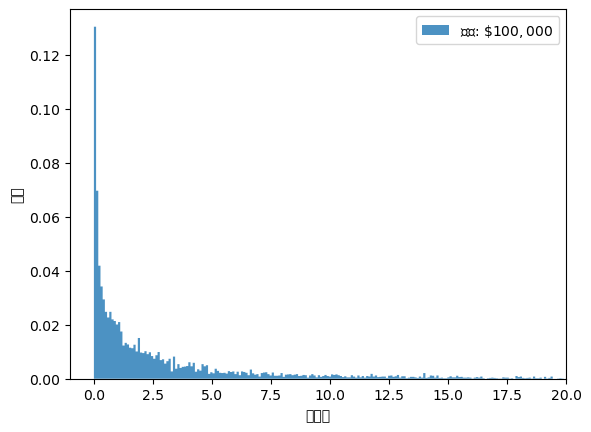

In [4]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.set_xlim(-1, 20)
density, edges = np.histogram(sample, bins=5000, density=True)
prob = density * np.diff(edges)
plt.stairs(prob, edges, fill=True, alpha=0.8, label=r"单位: $\$100,000$")
plt.ylabel("概率")
plt.xlabel("净财富")
plt.legend()
plt.show()

直方图显示许多人拥有非常低的财富，而少数人拥有非常高的财富。

我们将把全部人口规模设为

In [5]:
N = 100_000_000

我们如何使用样本数据估计全体人口的总收入呢？

我们的计划是假设每个人的财富都是从一个密度为 $f$ 的分布中抽取的。

如果我们获得了 $f$ 的估计值，就可以近似如下：

$$
    T = \sum_{i=1}^{N} h(w_i) 
      = N \frac{1}{N} \sum_{i=1}^{N} h(w_i) 
      \approx N \int_{0}^{\infty} h(w)f(w) dw
$$ (eq:est_rev)

(根据大数法则，样本均值应该接近总体均值。)

现在的问题是：我们如何估计 $f$？


## 最大似然估计

[最大似然估计](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) 
是一种估计未知分布的方法。

最大似然估计包括两个步骤：

1. 猜测基础的分布是什么（例如，均值为 $\mu$ 和
   标准差为 $\sigma$ 的正态分布）。
2. 估计参数值（例如，估计正态分布的 $\mu$ 和 $\sigma$）

对财富的一个可能假设是每个
$w_i$ 是[对数正态分布](https://en.wikipedia.org/wiki/Log-normal_distribution)，
参数为 $\mu \in (-\infty,\infty)$ 和 $\sigma \in (0,\infty)$。

（这意味着 $\ln w_i$ 是均值为 $\mu$ 和标准差为 $\sigma$ 的正态分布。）

您可以看到这个假设并非完全没有道理，因为如果我们绘制对数财富而不是财富的直方图，图形开始看起来像正态分布的钟形曲线。

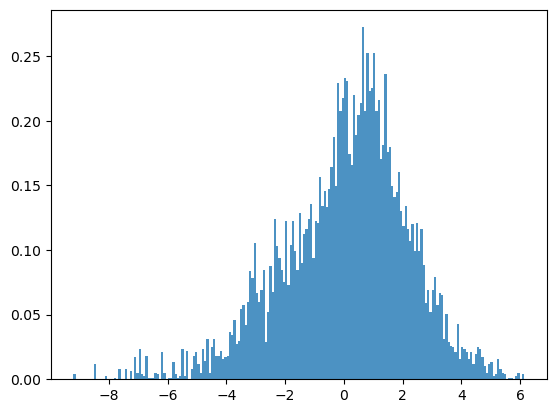

In [6]:
ln_sample = np.log(sample)
fig, ax = plt.subplots()
ax.hist(ln_sample, density=True, bins=200, histtype='stepfilled', alpha=0.8)
plt.show()

现在我们的任务是求出 $\mu$ 和 $\sigma$ 的最大似然估计值，我们记作 $\hat{\mu}$ 和 $\hat{\sigma}$。

这些估计值可以通过最大化给定数据的似然函数找到。

对数正态分布的随机变量 $X$ 的概率密度函数 (pdf) 为：

$$
    f(x, \mu, \sigma) 
    = \frac{1}{x}\frac{1}{\sigma \sqrt{2\pi}} 
    \exp\left(\frac{-1}{2}\left(\frac{\ln x-\mu}{\sigma}\right)\right)^2
$$

对于我们的样本 $w_1, w_2, \cdots, w_n$，[似然函数](https://en.wikipedia.org/wiki/Likelihood_function) 给出为

$$
    L(\mu, \sigma | w_i) = \prod_{i=1}^{n} f(w_i, \mu, \sigma)
$$

似然函数可以视为

* 样本的联合分布（假设是独立同分布的）和
* 给定数据的参数 $(\mu, \sigma)$ 的“似然”。

对两边取对数得到对数似然函数，即为

$$
\begin{aligned}
    \ell(\mu, \sigma | w_i) 
    & = \ln \left[ \prod_{i=1}^{n} f(w_i, \mu, \sigma) \right] \\
    & = -\sum_{i=1}^{n} \ln w_i 
        - \frac{n}{2} \ln(2\pi) - \frac{n}{2} \ln \sigma^2 - \frac{1}{2\sigma^2}
            \sum_{i=1}^n (\ln w_i - \mu)^2
\end{aligned}
$$

为了找到这个函数的最大值，我们求它对 $\mu$ 和 $\sigma ^2$ 的偏导数并将其设为零。

我们首先求 $\mu$ 的最大似然估计 (MLE)

$$
\frac{\delta \ell}{\delta \mu} 
    = - \frac{1}{2\sigma^2} \times 2 \sum_{i=1}^n (\ln w_i - \mu) = 0 \\
\implies \sum_{i=1}^n \ln w_i - n \mu = 0 \\
\implies \hat{\mu} = \frac{\sum_{i=1}^n \ln w_i}{n}
$$

现在我们求 $\sigma$ 的 MLE

$$
\frac{\delta \ell}{\delta \sigma^2} 
    = - \frac{n}{2\sigma^2} + \frac{1}{2\sigma^4} 
    \sum_{i=1}^n (\ln w_i - \mu)^2 = 0 \\
    \implies \frac{n}{2\sigma^2} = 
    \frac{1}{2\sigma^4} \sum_{i=1}^n (\ln w_i - \mu)^2 \\
    \implies \hat{\sigma} =  \left( \frac{\sum_{i=1}^{n}(\ln w_i - \hat{\mu})^2}{n} \right)^{1/2}
$$

现在我们已经推导出了 $\hat{\mu}$ 和 $\hat{\sigma}$ 的表达式，让我们计算我们的财富样本。

In [7]:
μ_hat = np.mean(ln_sample)
μ_hat

0.0634375526654064

In [8]:
num = (ln_sample - μ_hat)**2
σ_hat = (np.mean(num))**(1/2)
σ_hat

2.1507346258433424

让我们使用估计的参数绘制对数正态 pdf 和我们的样本数据。

/home/humphrey/anaconda3/envs/quantecon/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/humphrey/anaconda3/envs/quantecon/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/humphrey/anaconda3/envs/quantecon/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/humphrey/anaconda3/envs/quantecon/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24577 (\N{CJK UNIFIED IDEOGRAPH-6001}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


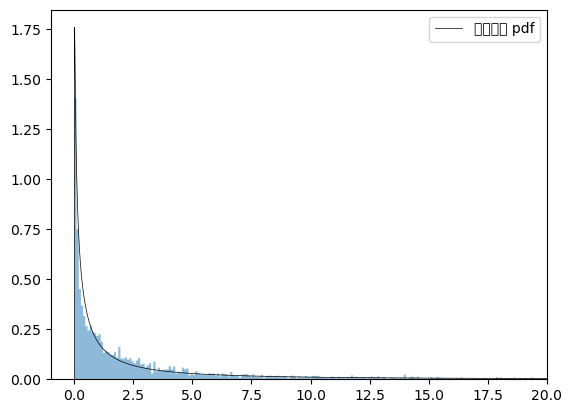

In [9]:
dist_lognorm = lognorm(σ_hat, scale = exp(μ_hat))
x = np.linspace(0,50,10000)

fig, ax = plt.subplots()
ax.set_xlim(-1,20)

ax.hist(sample, density=True, bins=5_000, histtype='stepfilled', alpha=0.5)
ax.plot(x, dist_lognorm.pdf(x), 'k-', lw=0.5, label='对数正态 pdf')
ax.legend()
plt.show()

# Pareto 分布

另一种假设基础分布是 [Pareto 分布](https://en.wikipedia.org/wiki/Pareto_distribution)。

这是另一种常用于描述财富分布的分布。

在肌肉的尺寸、城市的大小、公司收入以及收入和财富中，“Pareto 分布”起着至关重要的作用。

假设 $X$ 是一个 Pareto 分布的随机变量，其 pdf 为

$$
    f(x, \gamma, x_m) = \gamma \frac{x_m^\gamma}{x^{\gamma+1}}
    1_{x \geq x_m}
$$

其中 $\gamma$ 和 $x_m$ 是正参数。

对于一个样本 $w_1, w_2, \cdots, w_n$，称为 `sample`，其似然函数为

$$
    L(\gamma, x_m) 
    = \prod_{i=1}^{n} 
    \gamma \frac{x_m^\gamma}{w_i^{\gamma+1}} 1_{w_i \geq x_m}
$$

然后对数似然为

$$
\ell(\gamma, x_m | w_i)
= \sum_{i=1}^n \ln \left[ \gamma \frac{x_m^\gamma}{w_i^{\gamma+1}} 1_{w_i \geq x_m}\right]
= n \ln \gamma + n\gamma\ln x_m 
    - (\gamma+1) \sum_{i=1}^{n} \ln w_i 
$$

为了避免不可行解，我们可以将 $x_m$ 设定为观测到的 $w_i$s 的最小值。

In [10]:
x_m = min(sample)
γ_hat = len(sample) / np.sum(np.log(sample / x_m))
γ_hat, x_m

(0.10783091940803055, 0.0001)

我们使用估计参数绘制 Pareto pdf 和我们的样本数据。

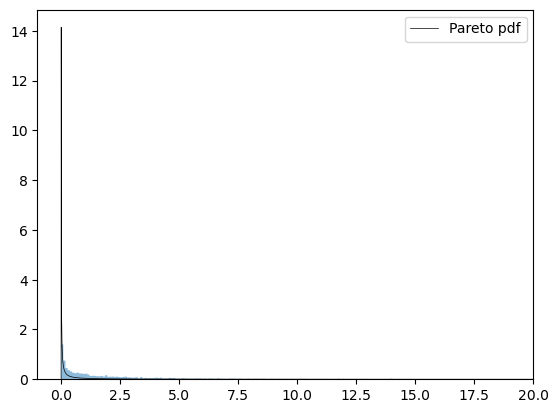

In [11]:
dist_pareto = pareto(γ_hat, scale = x_m)
fig, ax = plt.subplots()
ax.set_xlim(-1,20)

ax.hist(sample, density=True, bins=5000, histtype='stepfilled', alpha=0.5)
ax.plot(x, dist_pareto.pdf(x), 'k-', lw=0.5, label='Pareto pdf')
ax.legend()
plt.show()

## 总税收计算

为了近似 $N$ 人的总税收 $T$（参见 {eq}`est_rev`），我们将使用 Monte Carlo 模拟。

我们从拟合的 Pareto 分布中生成 $w_1, \cdots, w_N$ 的样本，并计算 $\sum_{i=1}^{N}h(w_i)$。

In [12]:
draws = dist_pareto.rvs(N, random_state=0)
tax = np.vectorize(h)(draws, a=0.05, b=0.1, w_bar=2.5)
T_hat = np.sum(tax)
T_hat

NameError: name 'h' is not defined

再做一次，从对数正态分布中绘制样本。

In [ ]:
draws_log = dist_lognorm.rvs(N, random_state=0)
tax_log = np.vectorize(h)(draws_log, a=0.05, b=0.1, w_bar=2.5)
T_hat_log = np.sum(tax_log)
T_hat_log

在我们的例子中，似乎估计通过财富税筹集的收入的蒙特卡罗结果是可行的。

当然，这在很大程度上取决于我们对财富分布的假设。

为了增加可信度，我们应该仔细研究每个分布的良好拟合度。

## 练习

1. 使用 lognorm 替换 scipy.stats 中的 Pareto 并重新计算总收入。
2. 探索在估计总收入时不同的刻度和参数。


# 比较

第一个估计是基于拟合的 Pareto 分布，而第二个估计是基于对数正态分布。

这两个数量都表现为占 GDP 的百分比。

In [ ]:
tr_pareto = f"Pareto 分布产生的总税收/GDP 比率： {TR_GDP_ratio_pareto:.4f}"
tr_lognorm = f"对数正态分布产生的总税收/GDP 比率： {TR_GDP_ratio_log:.4f}"
(tr_pareto, tr_lognorm)

数量非常不同！

In [ ]:
tr_pareto / tr_lognorm

由此，我们看到选择合适的分布是极其重要的。

让我们将拟合的 Pareto 分布与直方图进行比较：

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim(-1, 20)
ax.set_ylim(0,1.75)

ax.hist(sample, density=True, bins=5_000, histtype='stepfilled', alpha=0.5)
ax.plot(x, dist_pareto.pdf(x), 'k-', lw=0.5, label='Pareto pdf')
ax.legend()

plt.show()

我们观察到，在这种情况下，对于 Paret o分布的拟合并不是很好的，因此我们可能可以拒绝它。

## 最佳分布是什么？

没有“最佳”分布——我们做出的每个选择都是一个假设。

我们能做的只是尝试选择一个与数据吻合良好的分布。

上面的图表表明对数正态分布是最优的。

但是，当我们检查上尾（最富有的人）时，Pareto 分布可能更适合。

要看到这一点，我们现在在数据集中设置一个最低净资产阈值。

我们设定一个任意的 $500,000 阈值，并将数据读入 `sample_tail`。

In [ ]:
df_tail = df.loc[df['n_wealth'] > 500_000 ]
df_tail.head()
rv_tail = df_tail['n_wealth'].sample(n=10_000, random_state=4321)
rv_tail = rv_tail.to_numpy()
sample_tail = rv_tail/500_000

注意我们对刻度的改变。它会影响我们最终的输入。

让我们绘制这些数据。

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim(0,50)
ax.hist(sample_tail, density=True, bins=500, histtype='stepfilled', alpha=0.8)
plt.show()

### 右尾的对数正态分布

让我们从对数正态分布开始。

我们再次估计参数并将密度绘制到我们的数据上。

In [ ]:
ln_sample_tail = np.log(sample_tail)
μ_hat_tail = np.mean(ln_sample_tail)
num_tail = (ln_sample_tail - μ_hat_tail)**2
σ_hat_tail = (np.mean(num_tail))**(1/2)
dist_lognorm_tail = lognorm(σ_hat_tail, scale = exp(μ_hat_tail))

fig, ax = plt.subplots()
ax.set_xlim(0,50)
ax.hist(sample_tail, density=True, bins=500, histtype='stepfilled', alpha=0.5)
ax.plot(x, dist_lognorm_tail.pdf(x), 'k-', lw=0.5, label='对数正态 pdf')
ax.legend()
plt.show()

虽然对数正态分布适合整个数据集，但它并不适合右尾。

### 右尾的 Pareto 分布

现在让我们假设截尾数据集符合 Pareto 分布。

我们再次估计参数并将密度绘制到我们的数据上。

In [ ]:
xm_hat_tail = min(sample_tail)
den_tail = np.log(sample_tail/xm_hat_tail)
b_hat_tail = 1/np.mean(den_tail)
dist_pareto_tail = pareto(b = b_hat_tail, scale = xm_hat_tail)

fig, ax = plt.subplots()
ax.set_xlim(0, 50)
ax.set_ylim(0,0.65)
ax.hist(sample_tail, density=True, bins= 500, histtype='stepfilled', alpha=0.5)
ax.plot(x, dist_pareto_tail.pdf(x), 'k-', lw=0.5, label='Pareto pdf')
plt.show()

Pareto 分布更适合我们数据的右尾。

### 所以最佳分布是什么？

正如我们上面所说，没有“最佳”分布——每个选择都是一个假设。

我们只需测试我们认为合理的分布。

一种测试方法是绘制数据与拟合分布的对比，就像我们做的那样。

还有其他更严格的测试，例如 [Kolmogorov-Smirnov 检验](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)。

我们省略了这些高级主题（但鼓励读者在完成这些讲座后进行研究）。

## 练习

```{exercise-start}
:label: mle_ex1
```
假设我们假设财富呈 [指数分布](https://en.wikipedia.org/wiki/Exponential_distribution)，参数为 $\lambda > 0$。

$\lambda$ 的最大似然估计值为

$$
\hat{\lambda} = \frac{n}{\sum_{i=1}^n w_i}
$$

1. 计算我们最初样本的 $\hat{\lambda}$。
2. 使用 $\hat{\lambda}$ 计算总税收

```{exercise-end}
```

```{solution-start} mle_ex1
:class: dropdown
```

In [ ]:
λ_hat = 1/np.mean(sample)
λ_hat

In [ ]:
dist_exp = expon(scale = 1/λ_hat)
tr_expo = total_revenue(dist_exp) 
tr_expo

```{solution-end}
```

```{exercise-start}
:label: mle_ex2
```

将指数分布绘制在样本上，并检查其是否适合。

```{exercise-end}
```

```{solution-start} mle_ex2
:class: dropdown
```

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim(-1, 20)

ax.hist(sample, density=True, bins=5000, histtype='stepfilled', alpha=0.5)
ax.plot(x, dist_exp.pdf(x), 'k-', lw=0.5, label='指数 pdf')
ax.legend()

plt.show()

显然，这种分布并不适合我们的数据。

```{solution-end}
```